In [1]:
import requests
import pandas as pd
import numpy as np
import time, json
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d as blur

# Prepare Data

Prepare the API call, specify parameters to use in the call, and call the API. Then convert the response to a Pandas dataframe.

In [2]:
lat, lon = 49.417146, 8.675606
# hourly: "temperature_2m", "pressure_msl", "relativehumidity_2m", "precipitation", "cloudcover", "shortwave_radiation", "windspeed_10m"
hourly_vars = "temperature_2m,pressure_msl,relativehumidity_2m,precipitation,cloudcover,shortwave_radiation,windspeed_10m"

url = f"https://archive-api.open-meteo.com/v1/era5?latitude={lat}&longitude={lon}&start_date=2021-07-26&end_date=2021-07-30&hourly={hourly_vars}"

url = url.format(lat=lat, lon=lon, hourly_vars=hourly_vars)

In [3]:
r = requests.get(url)
data = json.loads(r.text)

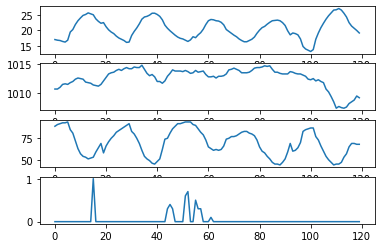

In [4]:
# test plot to see if the data was loaded correctly

plt.subplot(4,1,1)
plt.plot(data["hourly"]["temperature_2m"])

plt.subplot(4,1,2)
plt.plot(data["hourly"]["pressure_msl"])

plt.subplot(4,1,3)
plt.plot(data["hourly"]["relativehumidity_2m"])

plt.subplot(4,1,4)
plt.plot(data["hourly"]["precipitation"])

plt.show()

In [5]:
# convert time to 2d encoding
# imagine a circle with 24 points on it, each point represents an hour, similar to the 12 points on a clock
# the x coordinate of a point is sin(t/12*pi), the y coordinate is cos(t/12*pi)
# this way, 23:00 and 1:00 are close to each other
def time2d(t):
    return np.array([np.sin(t/12*np.pi), np.cos(t/12*np.pi)])

In [6]:
# convert data to pandas dataframe and split into training and future data

df = pd.DataFrame(data["hourly"], columns=hourly_vars.split(","))
times = data["hourly"]["time"]
times_2d = np.array([time2d(time.strptime(t, "%Y-%m-%dT%H:%M").tm_hour) for t in times])
df["time_sin"] = times_2d[:,0]
df["time_cos"] = times_2d[:,1]
# restrict df to first 72 hours, save others to df_future
df_future = df[72:]
df = df[:72]

times_future = times[72:]
times = times[:72]

df

,temperature_2m,pressure_msl,relativehumidity_2m,precipitation,cloudcover,shortwave_radiation,windspeed_10m,time_sin,time_cos
0,17.1,1010.7,89,0.0,41,0.0,5.7,0.000000,1.000000
1,16.9,1010.7,91,0.0,36,0.0,6.0,0.258819,0.965926
2,16.8,1011.0,92,0.0,41,0.0,7.5,0.500000,0.866025
3,16.5,1011.5,93,0.0,43,0.0,7.1,0.707107,0.707107
4,16.3,1011.6,93,0.0,29,0.0,7.2,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...
67,20.3,1013.3,74,0.0,51,22.0,12.8,-0.965926,0.258819
68,19.7,1014.0,75,0.0,39,0.0,12.8,-0.866025,0.500000
69,19.1,1014.1,77,0.0,11,0.0,13.3,-0.707107,0.707107
70,18.5,1014.3,77,0.0,17,0.0,13.7,-0.500000,0.866025


In [7]:
# store normalisation data for later use

normalisation = {
    "min": list(df.min().values),
    "max": list(df.max().values),
    "spread": list((df.max() - df.min()).values)
}

In [8]:
# smooth out data
#   otherwise the small model won't be able to capture the trends,
#   it's not expressive enough to capture the little details

for col in df.columns:
    df[col] = blur(df[col], 2)
    df_future[col] = blur(df_future[col], 2)

In [9]:
# scale data to [0,1]
df_norm = (df - normalisation["min"]) / normalisation["spread"]

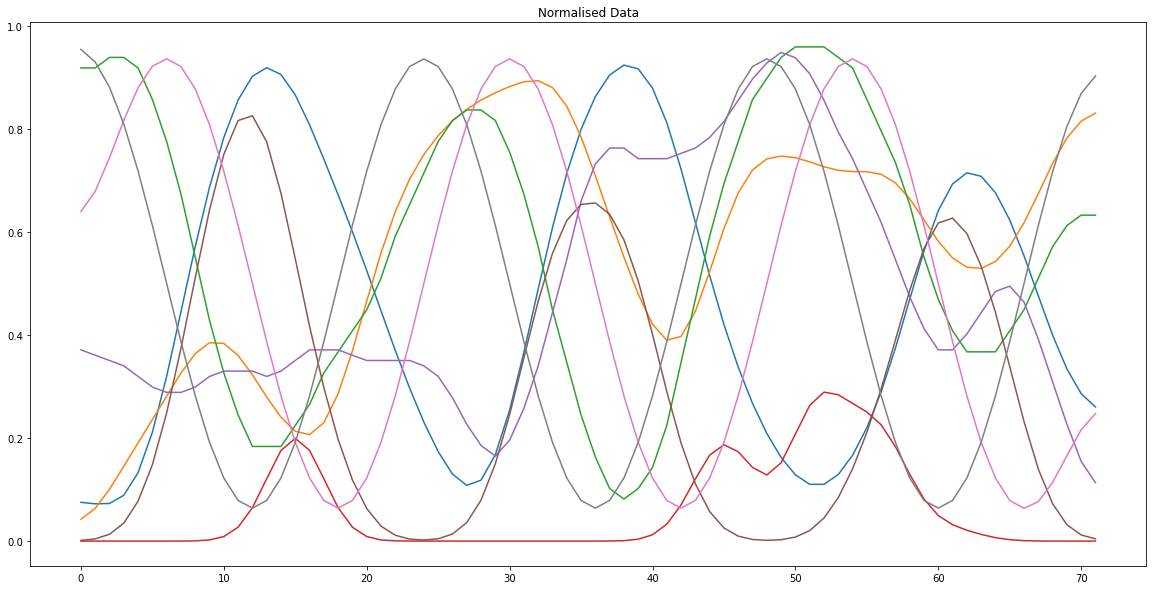

In [10]:
plt.figure(figsize=(20,10))
plt.title("Normalised Data")
plt.plot(df_norm["temperature_2m"])
plt.plot(df_norm["pressure_msl"])
plt.plot(df_norm["relativehumidity_2m"])
plt.plot(df_norm["precipitation"])
plt.plot(df_norm["cloudcover"])
plt.plot(df_norm["shortwave_radiation"])
plt.plot(df_norm["time_sin"])
plt.plot(df_norm["time_cos"])
plt.show()

In [11]:
# restrict data on every 3rd hour
#   we want to see whether the model can still
#   pick up the trends with only every 3rd hour
#   given

REDUCTION = 3

df_norm_red = df_norm.iloc[::REDUCTION, :]
df_red = df.iloc[::REDUCTION, :]

# Neural ODE

In [12]:
from torch import nn
import torch
from torchdiffeq import odeint

In [13]:
def get_batch(x: np.ndarray, t: np.ndarray,
               batch_size: int, batch_length: int):
    """Get a random batch of data from the dataset.

    Args:
        x: The dataset.
        t: The time points corresponding to the dataset.
        batch_size: The number of trajectories in the batch.
        batch_length: The length of each trajectory.

    Returns:
        batch_x0: A random batch of data from the dataset.
        batch_t: The time points corresponding to the batch_x data.
        batch_x: The batch of data.
    """
    idx = np.random.choice(range(len(x)-batch_length-1),
                            batch_size, replace=False)
    batch_x0 = x[idx]
    batch_t = t[:batch_length]
    batch_x = np.stack([x[idx+i] for i in range(batch_length)], axis=0)
    # convert to torch tensors
    batch_x0 = torch.tensor(batch_x0, dtype=torch.float32)
    batch_t = torch.tensor(batch_t, dtype=torch.float32)
    batch_x = torch.tensor(batch_x, dtype=torch.float32)
    return batch_x0, batch_t, batch_x

In [14]:
class NeuralODE(nn.Module):
    def __init__(self, dim, hidden_size, hidden_layers):
        """Parameters:
        dim: dimension of input and output
        hidden_size: size of hidden layers
        hidden_layers: number of hidden layers
        
        example: NeuralODE(3, 20, 2) creates a neural ODE with 3 input and output dimensions, 2 hidden layers with 20 neurons each"""
        
        super(NeuralODE, self).__init__()
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(nn.Linear(dim, hidden_size))
        # hidden layers
        for _ in range(hidden_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        # output layer
        self.layers.append(nn.Linear(hidden_size, dim))
        # activation function
        self.act = nn.ReLU()

        # initialize weights
        for layer in self.layers[:-1]:
            nn.init.normal_(layer.weight, mean=0, std=0.1)
            nn.init.constant_(layer.bias, 0)

    def forward(self, t, x):
        # apply layers and activation function
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

In [15]:
# initialize model with same dimensions as data
model = NeuralODE(len(df.columns), 256, 3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
# number of parameters
print('Number of parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of parameters:  202249


Training was a bit finicky, here is what we found to work best:

The model first has to predict short time spans for which the error is then computed and the model updated accordingly. Then the time span to predict gets longer and longer. Once the got some kind of "feeling" for semi long time spans, we go back to short time spans and repeat the process. Now we continue up to the full time span length.

Imagine teaching a kid how to write a story. You start by teaching it letters, then words, finally grammar and sentence structure. When you introduced something more complicated like grammar, you go back to earlier concepts to make sure these are remembered correctly. Then you continue on with more and more complicated concepts.

However, just feel free to play around with this, to get an intuiton for yourself on what works best.

Epoch:    0, Loss: 0.1719, Length:   2          
Epoch:  150, Loss: 0.0087, Length:   2          
Epoch:  300, Loss: 0.0208, Length:   4          
Epoch:  449, Loss: 0.0127, Length:   5          
--------------------

Epoch:    0, Loss: 0.0048, Length:   2          
Epoch:  150, Loss: 0.0029, Length:   2          
Epoch:  300, Loss: 0.0144, Length:   4          
Epoch:  450, Loss: 0.0114, Length:   6          
Epoch:  600, Loss: 0.0120, Length:   8          
Epoch:  749, Loss: 0.0174, Length:   9          

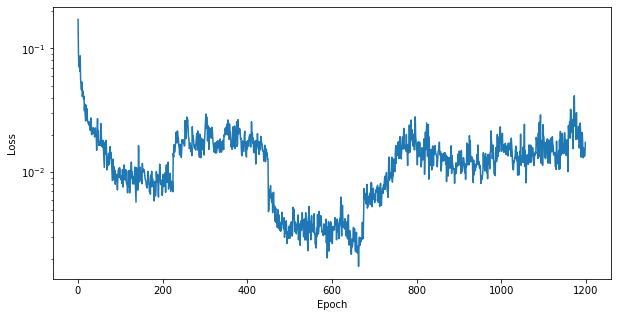


Training time: 429.96s


In [17]:
training = False

if training:
    start_time = time.time()

    BATCH_SIZE = 6
    MAX_BATCH_LENGTH = 32//REDUCTION
    EPOCHS = 750

    times_tensor = np.arange(0, len(times), 3, dtype=np.float32)

    loss_hist = []

    # initial training
    for epoch in range(450):
        batch_length = max(int(epoch / EPOCHS * MAX_BATCH_LENGTH), 2)

        batch_x0, batch_t, batch_x = get_batch(df_norm_red.values, times_tensor, BATCH_SIZE, batch_length)
        pred_x = odeint(model, batch_x0, batch_t)
        loss = torch.mean(torch.abs(pred_x - batch_x))
        optim.zero_grad()
        loss.backward()
        optim.step()
        print('\rEpoch: {:4d}, Loss: {:.4f}, Length: {:3d}'.format(epoch, loss.item(), batch_length), end=' '*10)
        loss_hist.append(loss.item())
        if epoch % (EPOCHS//5) == 0:
            print()

    print()
    print("-"*20)
    print()

    # training with longer trajectories
    for epoch in range(EPOCHS):
        batch_length = max(int(epoch / EPOCHS * MAX_BATCH_LENGTH), 2)

        batch_x0, batch_t, batch_x = get_batch(df_norm_red.values, times_tensor, BATCH_SIZE, batch_length)
        pred_x = odeint(model, batch_x0, batch_t)
        loss = torch.mean(torch.abs(pred_x - batch_x))
        optim.zero_grad()
        loss.backward()
        optim.step()
        print('\rEpoch: {:4d}, Loss: {:.4f}, Length: {:3d}'.format(epoch, loss.item(), batch_length), end=' '*10)
        loss_hist.append(loss.item())
        if epoch % (EPOCHS//5) == 0:
            print()

    plt.figure(figsize=(10,5))
    plt.semilogy(loss_hist)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    print()
    print("Training time: {:.2f}s".format(time.time() - start_time))

    torch.save(model.state_dict(), "data/ode_model.pt")
else:
    model.load_state_dict(torch.load("data/ode_model.pt"))

### Testing the trained model

In [18]:
# test model, i.e. let it predict starting from the initial value
test_x0 = df_norm.values[:1]
test_t = np.linspace(0, len(times), 3*len(times), dtype=np.float32)
test_x = odeint(model, torch.tensor(test_x0, dtype=torch.float32), torch.tensor(test_t, dtype=torch.float32)).detach().numpy()

In [19]:
# plot results
plt.figure(figsize=(15,7.5))
plt.subplot(3,1,1)
plt.plot(test_t, test_x[:,0,0], label="temp_pred")
plt.plot(times, df_norm["temperature_2m"], label="temp_true")
plt.plot(times[::REDUCTION], df_norm_red["temperature_2m"], label="temp_true_reduced")
plt.xticks([])
plt.xlim(0, 48)
plt.legend()

plt.subplot(3,1,2)
plt.plot(test_t, test_x[:,0,1], label="pressure_pred")
plt.plot(times, df_norm["pressure_msl"], label="pressure_true")
plt.plot(times[::REDUCTION], df_norm_red["pressure_msl"], label="pressure_true_reduced")
plt.xticks([])
plt.xlim(0, 48)
plt.legend()

plt.subplot(3,1,3)
plt.plot(test_t, test_x[:,0,3], label="precipitation_pred")
plt.plot(times, df_norm["precipitation"], label="precipitation_true")
plt.plot(times[::REDUCTION], df_norm_red["precipitation"], label="precipitation_true_reduced")
plt.xticks([])
plt.xlim(0, 48)
plt.legend()
plt.close()

In [20]:
# load predictions to dataframe
df_pred = pd.DataFrame(test_x[:,0,:], columns=df_norm.columns)
df_pred["time"] = test_t

In [21]:
# # save everything

# df.to_csv("data/weather_data.csv", index=False)
# df_norm.to_csv("data/weather_data_normalised.csv", index=False)
# df_red.to_csv("data/weather_data_training.csv", index=False)
# df_norm_red.to_csv("data/weather_data_normalised_training.csv", index=False)
# #save predictions
# df_pred.to_csv("data/weather_data_predictions.csv", index=False)
# # save values of normalisation
# with open("data/normalisation.json", "w") as f:
#     json.dump(normalisation, f)

In [22]:
# scale data back to real world values
test_x_np = test_x
for i, dim in enumerate(df.columns):
    test_x_np[:,:,i] = test_x_np[:,:,i] * normalisation["spread"][i] + normalisation["min"][i]


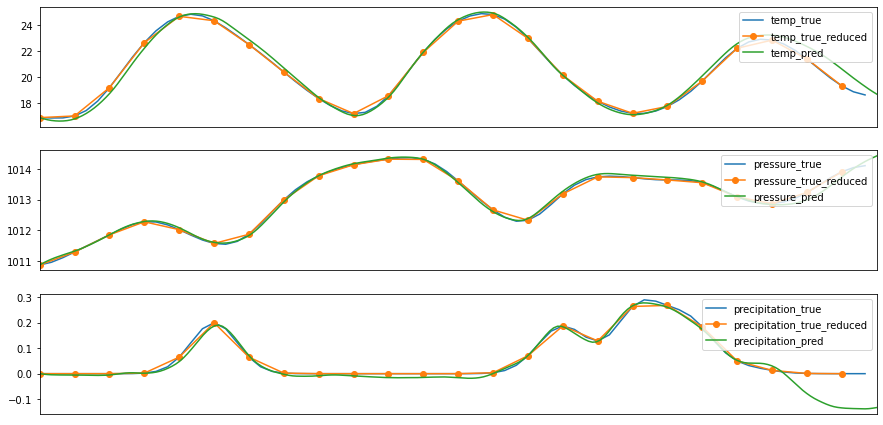

In [23]:
xstart = 0
xend = 72


if True:
    # plot results
    plt.figure(figsize=(15,7.5))
    plt.subplot(3,1,1)
    plt.plot(times, df["temperature_2m"], label="temp_true")
    plt.plot(times[::REDUCTION], df_red["temperature_2m"], marker="o", label="temp_true_reduced")
    plt.plot(test_t, test_x_np[:,0,0], label="temp_pred")
    plt.xticks([])
    plt.xlim(xstart, min(xend, len(times)))
    plt.legend(loc="upper right")

    plt.subplot(3,1,2)
    plt.plot(times, df["pressure_msl"], label="pressure_true")
    plt.plot(times[::REDUCTION], df_red["pressure_msl"], marker="o", label="pressure_true_reduced")
    plt.plot(test_t, test_x_np[:,0,1], label="pressure_pred")
    plt.xticks([])
    plt.xlim(xstart, min(xend, len(times)))
    plt.legend(loc="upper right")

    plt.subplot(3,1,3)
    plt.plot(times, df["precipitation"], label="precipitation_true")
    plt.plot(times[::REDUCTION], df_red["precipitation"], marker="o", label="precipitation_true_reduced")
    plt.plot(test_t, test_x_np[:,0,3], label="precipitation_pred")
    plt.xticks([])
    plt.legend(loc="upper right")
    plt.xlim(xstart, min(xend, len(times)))
    plt.show()